# Project 3

- Load (symmetric) TSP data from http://www.iwr.uni-heidelberg.de/groups/comopt/software/TSPLIB95/ 
  -> New link: http://elib.zib.de/pub/mp-testdata/tsp/tsplib/tsp/
- For opening the data use https://github.com/tsartsaris/TSPLIB-python-parser
- Apply the MMAS algorithm described in the exercise sheet

In [1]:
import numpy as np
import tsp_parser
import algorithms as algo
import viz
import utils
from matplotlib import pyplot as plt

%matplotlib inline

# Execute on gr24 problem

In [2]:
gr24_problem = tsp_parser.load_problem('data/gr24')
gr48_problem = tsp_parser.load_problem('data/gr48')
gr96_problem = tsp_parser.load_problem('data/gr96')

Stopped after 10.01 minutes


(1328,
 array([23, 11,  3,  0, 15, 10,  2, 17, 21, 16, 18, 14,  1, 19, 12,  8, 22,
        13,  9,  4, 20,  7,  6,  5]))

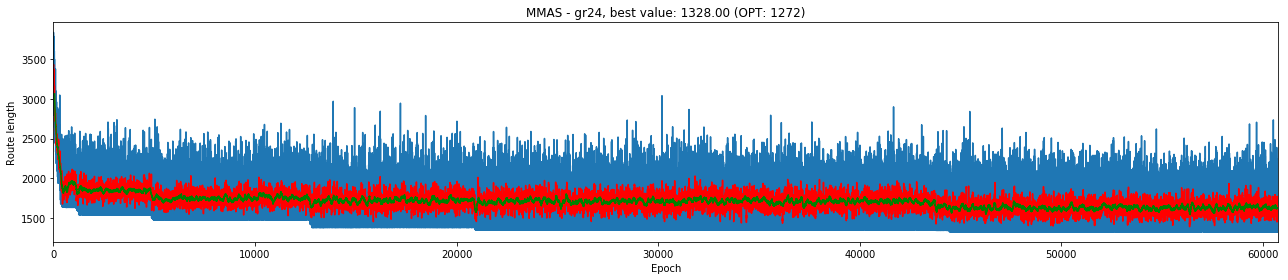

In [96]:
np.random.seed(0)  # Always produce the same random decisions (for debugging)
mmas = algo.MMAS(gr24_problem)
mmas()

Stopped after 0.74 minutes


(1272,
 array([ 7, 20,  4,  9, 16, 21, 17, 18, 14,  1, 19, 13, 12,  8, 22,  3, 11,
         0, 15, 10,  2,  6,  5, 23]))

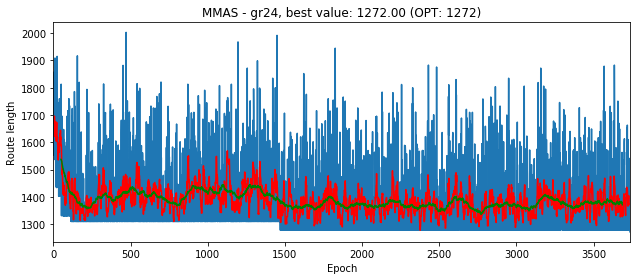

In [97]:
np.random.seed(0)
mmas = algo.MMAS(gr24_problem, wall_clock_time=10*60, beta=4)
mmas()

#### Results

Best solution: 1272  [ 16 11 3 7 6 24 8 21 5 10 17 22 18 19 15 2 20 14 13 9 23 4 12 1 ]

Our results (stopping after 10 minutes):
- Without heuristic information: 1328
- $\beta$ = 4:  1272  [ 7 20 4 9 16 21 17 18 14 1 19 13 12 8 22 3 11 0 15 10 2 6 5 23 ]

Conclusion:
- We found the same solution but shifted and with 0-based IDs
- Without $\beta$ we didn't find the solution within the 10 minutes. Using $\beta$ it took only ~45 seconds finding the optimal solution.

# Parameter tuning

In [119]:
# Take a harder example so it will be actually hard to find the best solution
print('Best solution for gr48: {}'.format(gr48_problem['opt']))

Best solution for gr48: 5046


alpha=2 beta=6 rho=0.0208 tau_min=0.0004 tau_max=47.9792


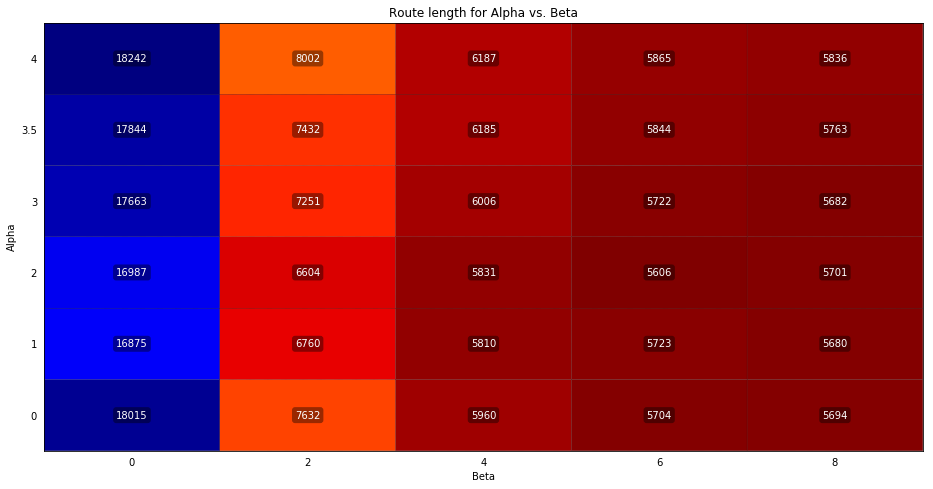

In [175]:
alphas=[0, 1, 2, 3, 3.5, 4]
betas=[0, 2, 4, 6, 8]
opt_params, costs = utils.grid_search(gr48_problem, alphas=alphas,
                                      betas=betas, runtime=1, tries=20)
print('alpha={} beta={} rho={:.4f} tau_min={:.4f} tau_max={:.4f}'.format(*opt_params))
utils.plot_parameter_heatmap(costs, (alphas, 'Alpha'), (betas, 'Beta'))
opt_alpha = 1  # opt_params[0]
opt_beta = opt_params[1]

alpha=3 beta=8 rho=0.0208 tau_min=0.0004 tau_max=47.9792


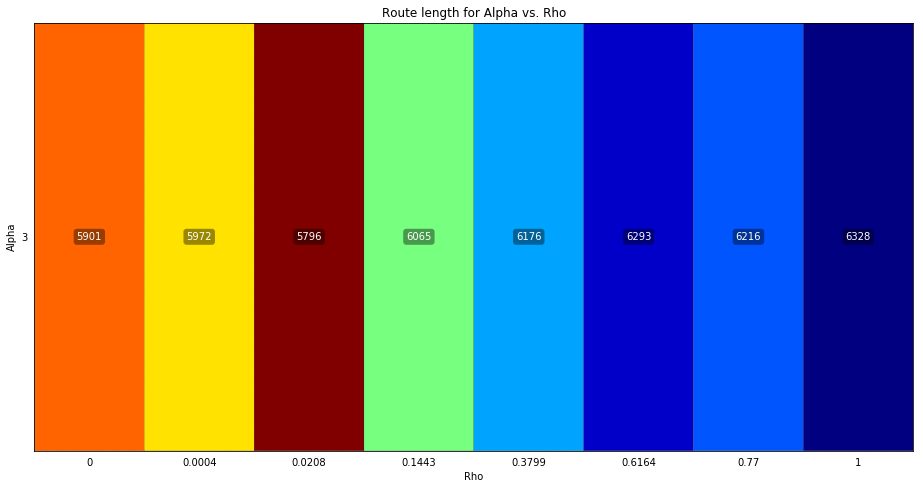

In [142]:
alphas=[opt_alpha]
n = gr48_problem['dimension']
rhos=[round(x, 4) for x in [0, 1/n**2, 1/n, 1/n**0.5, 1/n**0.25, 1/n**0.125, 1/n**0.0675, 1]]
opt_params, costs = utils.grid_search(gr48_problem, alphas=alphas,
                                      betas=[opt_beta], rhos=rhos, runtime=0.5, tries=10)
print('alpha={} beta={} rho={:.4f} tau_min={:.4f} tau_max={:.4f}'.format(*opt_params))
utils.plot_parameter_heatmap(costs, (alphas, 'Alpha'), (rhos, 'Rho'))

In [3]:
opt_rho = lambda n: 1/n

alpha=3 beta=8 rho=0.0208 tau_min=0.0004 tau_max=47.9792


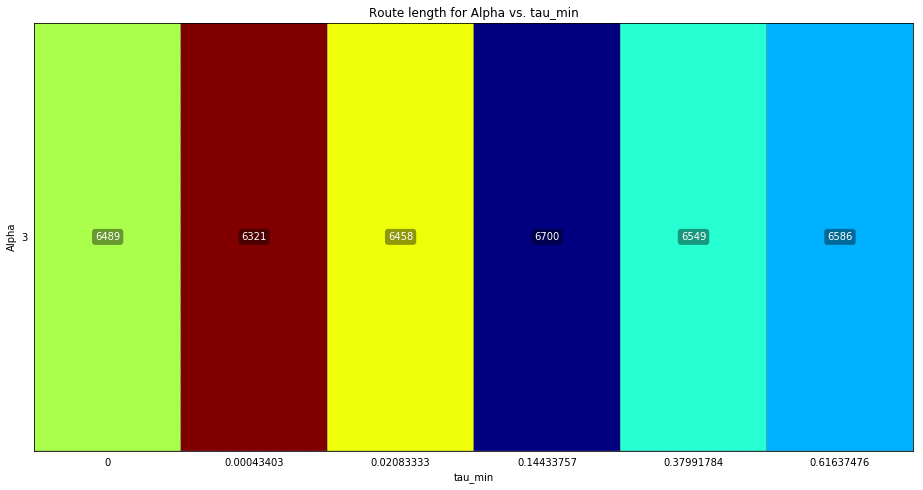

In [147]:
alphas=[opt_alpha]
n = gr48_problem['dimension']
# Applying a factor (e.g. 0,5 or 2) doesn't affect the results -> Change power value
tau_mins=[round(x, 8) for x in [0, 1/n**2, 1/n, 1/n**0.5, 1/n**0.25, 1/n**0.125]]
opt_params, costs = utils.grid_search(gr48_problem, alphas=alphas, betas=[opt_beta],
                                      rhos=[opt_rho(n)], tau_mins=tau_mins, runtime=0.1, tries=10)
print('alpha={} beta={} rho={:.4f} tau_min={:.4f} tau_max={:.4f}'.format(*opt_params))
utils.plot_parameter_heatmap(costs, (alphas, 'Alpha'), (tau_mins, 'tau_min'))

In [4]:
opt_tau_min = lambda n: 1/n**2

Execute this parameter tuning with 5 minutes wall clock time (instead of 1 second) for parameters which influence the performance on the long run.

In [ ]:
alphas=[1, 2, 3]
tau_maxs=[round(x, 8) for x in [0, 1-min(30, n/4)/n, 1-min(20, n/4)/n, 1-min(10, n/4)/n, 1-1/n, 1]]
n = gr48_problem['dimension']
opt_params, costs = utils.grid_search(gr48_problem, alphas=alphas, tau_maxs=tau_maxs,
                                      betas=[opt_beta], tau_mins=[opt_tau_min(n)], rhos=[opt_rho(n)], runtime=300, tries=1)
print('alpha={} beta={} rho={:.4f} tau_min={:.4f} tau_max={:.4f}'.format(*opt_params))
utils.plot_parameter_heatmap(costs, (alphas, 'Alpha'), (tau_maxs, 'tau_max'))

In [5]:
opt_tau_max = lambda n: 1/n

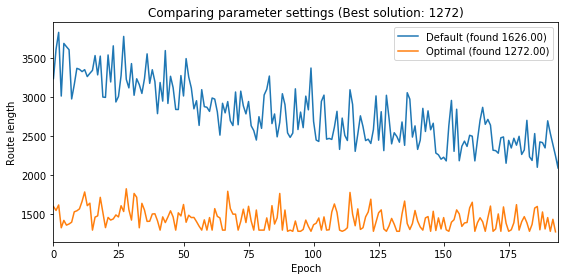

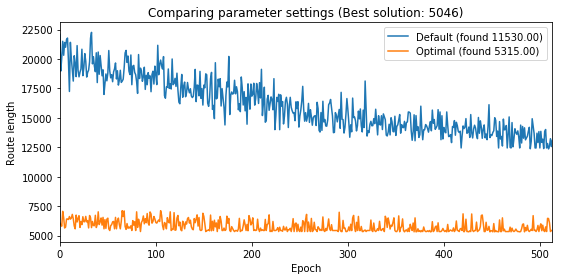

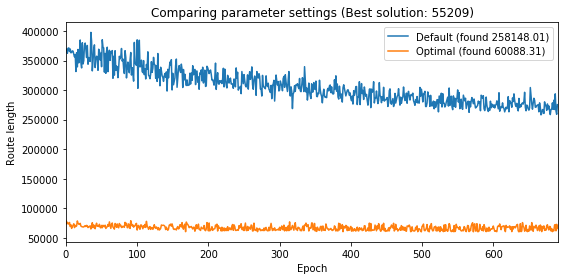

In [169]:
def generate_opt_setting(problem):
    n = problem['dimension']
    opt_setting = dict()
    opt_setting['alpha'] = opt_alpha
    opt_setting['beta'] = opt_beta
    opt_setting['rho'] = opt_rho(n)
    opt_setting['tau_min'] = opt_tau_min(n)
    opt_setting['tau_max'] = opt_tau_max(n)
    return opt_setting

# Evaluate best params on a short time interval
utils.evaluate_params(gr24_problem, generate_opt_setting(gr24_problem), runtime=10)
utils.evaluate_params(gr48_problem, generate_opt_setting(gr48_problem), runtime=20)
utils.evaluate_params(gr96_problem, generate_opt_setting(gr96_problem), runtime=40)

# Run on simple, middle and big problem for 10 minutes to evaluate if we can improve the solution
print('gr24:')
opt_setting = generate_opt_setting(gr24_problem)
algo.MMAS(gr24_problem, wall_clock_time=600)()
algo.MMAS(gr24_problem, wall_clock_time=600, **opt_setting)()

print('gr48:')
opt_setting = generate_opt_setting(gr48_problem)
algo.MMAS(gr48_problem, wall_clock_time=600)()
algo.MMAS(gr48_problem, wall_clock_time=600, **opt_setting)()

print('gr96:')
opt_setting = generate_opt_setting(gr96_problem)
algo.MMAS(gr96_problem, wall_clock_time=600)()
algo.MMAS(gr96_problem, wall_clock_time=600, **opt_setting)()

#### Conclusion (Parameter tuning)
- We executed the algorithm for each setting with a different walltime. e.g. t_max will be important on long runs so it was executed over 2 seconds (instead of 0.1)
- The performance of the algorithm strongly correlates with $\beta$. Good results always include a high value for $\beta$.
- To find the best parameters we would have to expand our search exponentially so we decided to find good parameters step by step
- Same of the parameters really depend on the size of the problem. We received different optimal parameters for $\rho$, $\tau_{min}$ and $\tau_{max}$ if we use gr24 instead of gr48.
- For $\rho$ it looks like $n^{-1}$ is a good parameter (assuming that it has to depend on $n$)
- For $\tau_{min}$ it looks like $n^{-2}$ is a good parameter (assuming that it has to depend on $n$)
- For $\tau_{min}$ it looks like $n^{-\frac{1}{2}}$ is a good parameter (assuming that it has to depend on $n$)
- Although we trained our parameters on a single problem we get much better results in three problems with different sizes
- Especially on the big problem (gr96) MMAS with our parameters found a much better solution which is actually very close to the optimal solution
- After the first execution of parameter tuning we got $\alpha=3$ as part of a good parameter setting. After testing on different problems with 10 minutes wall clock time we saw that the algorithm gets stuck not far away from the optimal solution - even on a small problem where it should be able to find the optimal solution. After defining $\alpha=1$ we executed the parameter tuning and the long time tests a second time and found better results.
- With these parameters on gr96 it's strongly fluctuating. Thus it's able to expand the search space and find good results.
- Resources: i5-6500U CPU 2.30GHz

Parameters for further tests: $\beta=8$ , $\alpha=1$ , $\rho=n^{-1}$ , $tau_{min}=n^{-2}$ , $tau_{max}=n^{-\frac{1}{2}}$

# TODO: Everything below

In [154]:
# Execute this if you want to changed the code within the python files
import imp
imp.reload(algo)
imp.reload(tsp_parser)
imp.reload(viz)
imp.reload(utils)

<module 'utils' from 'C:\\Users\\Thomas\\Documents\\Uni\\SS17\\nature-inspired\\project3\\utils.py'>

### Modify Algorithm (Optional)

In [ ]:
'''
    Max-Mint Ant System for solving the traveling salesman problem
    Parameters:
        problem - parsed tsp containing adjacent matrix, optimal solution, etc.
    Optional values (given as keyword arguments):
        rho  (default: 1 / n)
        tau_min  (default: 1 / n**2)
        tau_max  (default: n - 1 / n)
        alpha  (default: 1)
        beta  (default: 0)
        wall_clock_time  (default: 600 [seconds])
'''
class Batch_MMAS(algo.MMAS):
    # TODO: Override functions if you want to add ants, etc.
    def __init__(self, problem, **kwargs):
        super.__init__(problem, **kwargs)

### Test on different instances

### Extra credits

    1.) "Solving an instance from TSPLib with at least 40 cities optimally;"
    2.) "Solving an instance from TSPLib with at least 100 cities at most 1% worse than the optimum tour length;"
    3.) "Solving an instance from TSPLib with at least 1000 cities at most 30% worse than the optimum tour length;"
    4.) "Being the team which solved the highest-number-of-cities instance from TSPLib at most 50% worse than the optimum tour length."

"You might need to tune your algorithms some to make them good enough for these
extra credit items (and there is no time limit on these). Feel free to google for ideas
for how to improve ACO algorithms (I can recommend the paper by Stützle and Hoos
from 2000, Max-Min Ant System). Document your strategies, your results and your
resources used (“four cores at 2.3GHz for 24 hours. . . ”)."

In [6]:
# TODO: Add a problem with at least 100 cities
fnl4461_problem = tsp_parser.load_problem('data/fnl4461') # 1354

In [ ]:
np.random.seed(0)
opt_setting = generate_opt_setting(fnl4461_problem)
mmas = algo.MMAS(fnl4461_problem, wall_clock_time=600, **opt_setting)
route_length, costs = mmas()

In [7]:
dsj1000_problem = tsp_parser.load_problem('data/dsj1000') # 1354

Stopped after 540.00 minutes


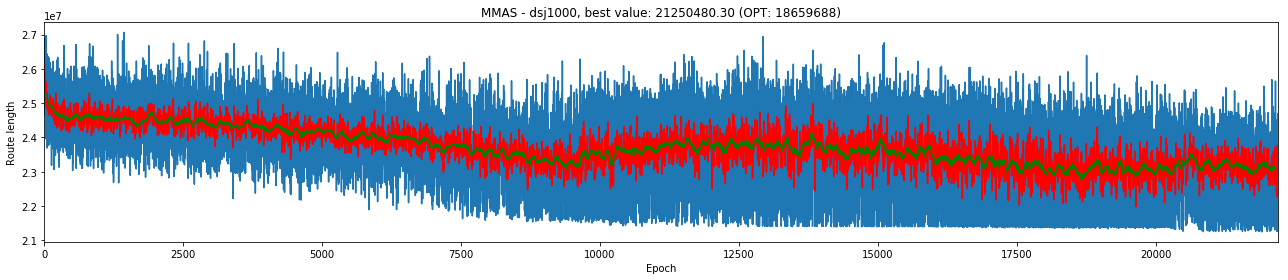

In [11]:
np.random.seed(0)
n = dsj1000_problem['dimension']
alpha = 1
beta = 8
rho = 1/n
tau_min = 1/n**2
tau_max=1-min(30, n/2)/n
mmas = algo.MMAS(dsj1000_problem, wall_clock_time=60*60*9, alpha=alpha, beta=beta, rho=rho, tau_min=tau_min, tau_max=tau_max)
route_length, costs = mmas()

9h: 21250480.3

opt = 1859688

117% of opt

In [ ]:
route_length, costs = mmas()

In [ ]:
route_length, costs = mmas()